In [1]:
# This block allows us to import from the benchmark folder,
# as if it was a package installed using pip
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from util import datasets, methods, models
from benchmark.sensitivity_n import sensitivity_n
import itertools
import numpy as np
from os import path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

In [3]:
# General parameters
batch_size = 16
n_batches = 16
n_subsets = 100
data_root = "../data"
use_logits = True
dataset_name = "MNIST"
normalize_attrs = False
aggregation_fn = None

In [4]:
# CIFAR10 parameters
if dataset_name == "CIFAR10":
    mask_range = list(range(1, 1000, 100))
    dataset = datasets.Cifar(batch_size=batch_size, data_location=path.join(data_root, "CIFAR10"), download=False, shuffle=False, version="cifar10")
    model = models.CifarResnet(version="resnet32", params_loc=path.join(data_root, "models/CIFAR10_resnet32.pth"), num_classes=10, output_logits=use_logits)
    model.eval()

In [5]:
# MNIST parameters
if dataset_name == "MNIST":
    mask_range = list(range(1, 700, 50))
    dataset = datasets.MNIST(batch_size=batch_size, data_location=path.join(data_root, "MNIST"), download=False, shuffle=False)
    model = models.MNISTCNN(params_loc=path.join(data_root, "models/MNIST_cnn.pth"), output_logits=use_logits)
    model.eval()

In [6]:
attribution_methods = {
    #"GuidedGradCAM": methods.GuidedGradCAM(model, model.get_last_conv_layer(), normalize=normalize_attrs),
    "Gradient": methods.Gradient(model, normalize=normalize_attrs, aggregation_fn=aggregation_fn),
    "InputXGradient": methods.InputXGradient(model, normalize=normalize_attrs, aggregation_fn=aggregation_fn),
    "IntegratedGradients": methods.IntegratedGradients(model, normalize=normalize_attrs, aggregation_fn=aggregation_fn),
    "GuidedBackprop": methods.GuidedBackprop(model, normalize=normalize_attrs, aggregation_fn=aggregation_fn),
    "Deconvolution": methods.Deconvolution(model, normalize=normalize_attrs, aggregation_fn=aggregation_fn),
    #"Random": methods.Random(normalize=normalize_attrs, aggregation_fn=aggregation_fn)
}

In [7]:
result = sensitivity_n(data=itertools.islice(dataset.get_dataloader(train=False), n_batches), model=model,
                       methods=attribution_methods, mask_range=mask_range,
                       n_subsets=100, mask_value=dataset.mask_value, pixel_level_mask=aggregation_fn is not None)

Batch 0...
Batch 1...
Batch 2...
Batch 3...
Batch 4...
Batch 5...
Batch 6...
Batch 7...
Batch 8...
Batch 9...
Batch 10...
Batch 11...
Batch 12...
Batch 13...
Batch 14...
Batch 15...


/home/arne/Documents/PhD/projects/benchmark/venv/lib/python3.6/site-packages/captum/attr/_utils/gradient.py:33: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index
/home/arne/Documents/PhD/projects/benchmark/venv/lib/python3.6/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:56: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  "Setting backward hooks on ReLU activations."


In [8]:
result_df = pd.DataFrame.from_dict(
    {m_name: pd.DataFrame(data=result[m_name]).fillna(0).stack() for m_name in attribution_methods}
).stack().reset_index()
result_df.columns = ["sample", "n", "method", "correlation"]
result_df["n"] = np.array(mask_range)[result_df["n"]]

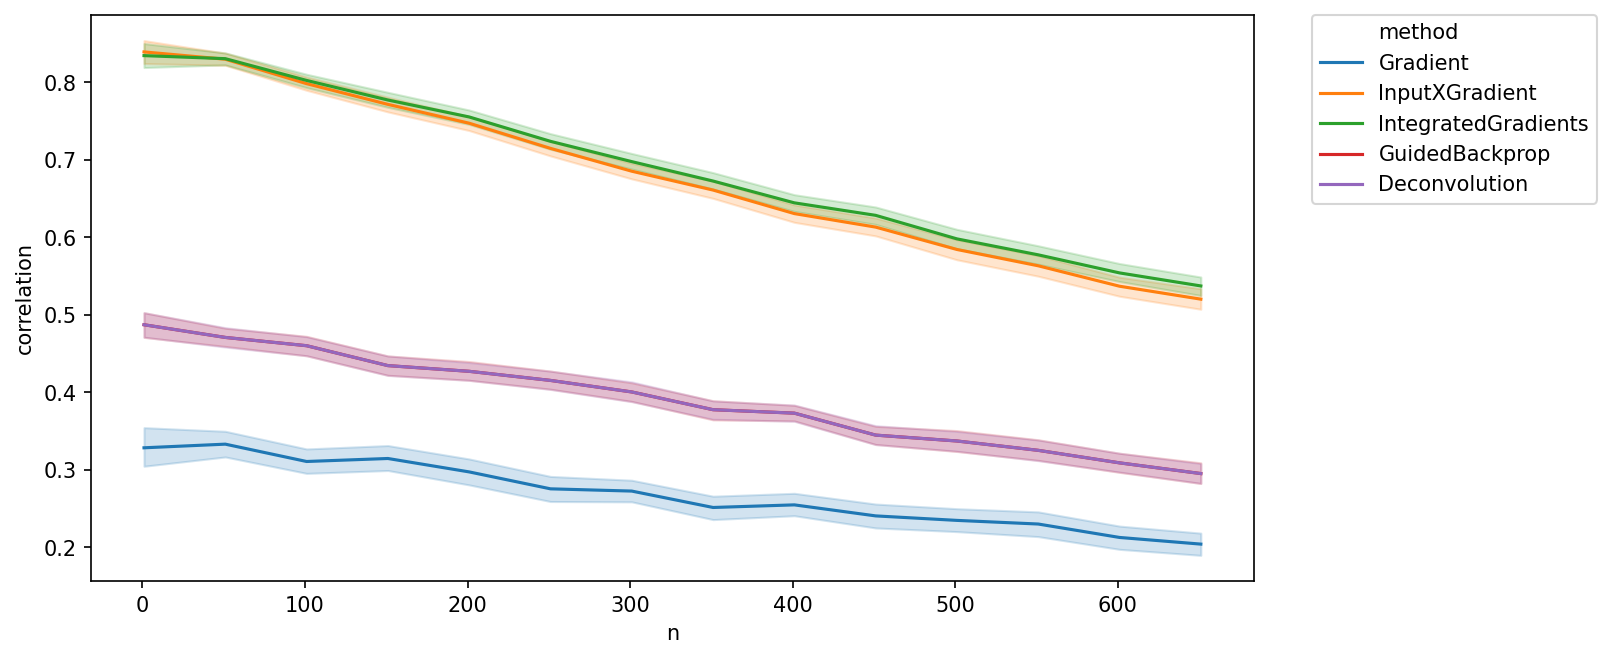

In [9]:
plt.figure(figsize=(10, 5))
sns.lineplot(x="n", y="correlation", hue="method", data=result_df)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)